In [47]:
# шаг 1: загрузка и обзор данных
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.mixture import GaussianMixture
df = pd.read_csv('baseball.csv')
df.head()

,Name,Team,nAtBat,nHits,nHome,nRuns,nRBI,nBB,YrMajor,CrAtBat,...,CrBB,League,Division,Position,nOuts,nAssts,nError,Salary,Div,logSalary
0,"Allanson, Andy",Cleveland,293,66,1,30,29,14,1,293,...,14,American,East,C,446,33,20,NaN,AE,NaN
1,"Ashby, Alan",Houston,315,81,7,24,38,39,14,3449,...,375,National,West,C,632,43,10,475.0,NW,6.163315
2,"Davis, Alan",Seattle,479,130,18,66,72,76,3,1624,...,263,American,West,1B,880,82,14,480.0,AW,6.173786
3,"Dawson, Andre",Montreal,496,141,20,65,78,37,11,5628,...,354,National,East,RF,200,11,3,500.0,NE,6.214608
4,"Galarraga, Andres",Montreal,321,87,10,39,42,30,2,396,...,33,National,East,1B,805,40,4,91.5,NE,4.516339


In [48]:
# шаг 2: обработка пропусков (knn imputing) и пересчёт logSalary

# knn-импутация по 3 соседям
df['Salary'] = df['Salary'].values.reshape(-1, 1)
imputer = KNNImputer(n_neighbors=3)
df[['Salary']] = imputer.fit_transform(df[['Salary']])
# пересчёт log(1 + salary)
df['logSalary'] = np.log1p(df['Salary'])


In [49]:
# шаг 3: нормализация числовых признаков и one-hot кодирование категориальных
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# определяем признаки
num_features = df.select_dtypes(include=[np.number]).columns.drop(['Salary'])
cat_features = df.select_dtypes(include=['object']).columns.drop('Name')

# строим препроцессор
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), list(num_features)),
    ('cat', OneHotEncoder(drop='first'), list(cat_features))
])

# применяем и получаем матрицу признаков
X_preprocessed = preprocessor.fit_transform(df.drop(columns=['Name']))



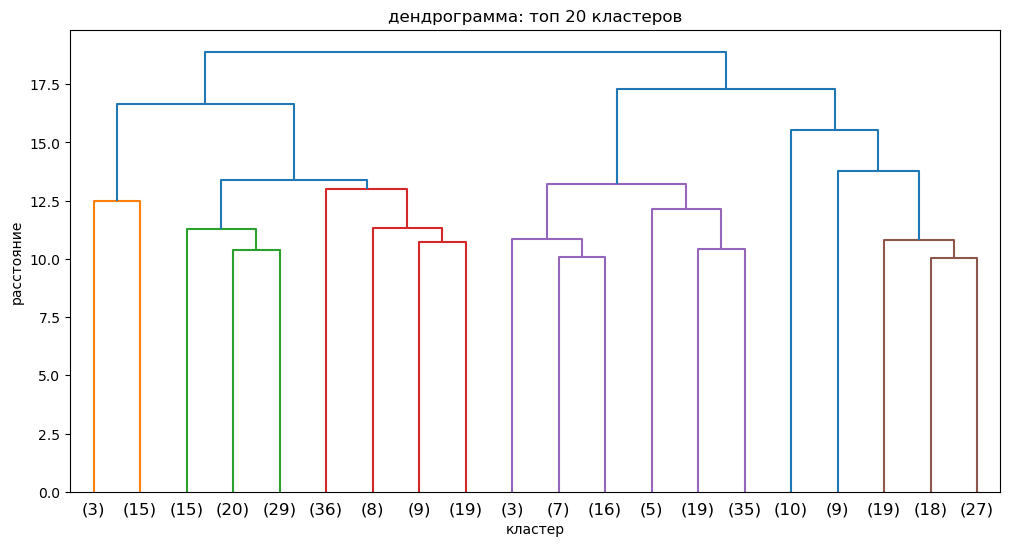

In [50]:
# шаг 4: иерархическая кластеризация и дендрограмма (20 кластеров)

X_preprocessed=X_preprocessed.toarray()
linkage_matrix = sch.linkage(X_preprocessed, method='complete', metric='cityblock')

plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=20)
plt.title('дендрограмма: топ 20 кластеров')
plt.xlabel('кластер')
plt.ylabel('расстояние')
plt.show()


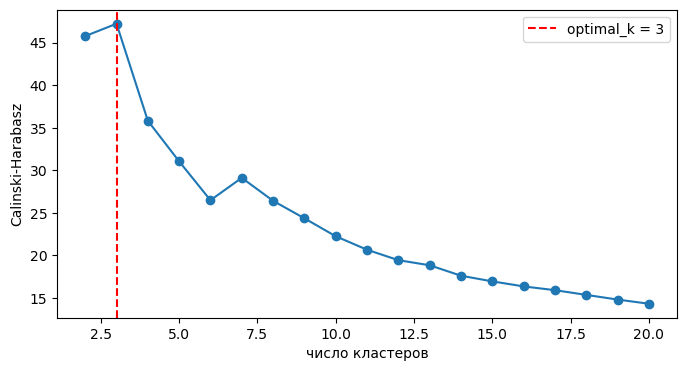

оптимальное число кластеров: 3


In [51]:
# шаг 5: расчет pseudo-F (критерия Calinski-Harabasz) для k=2..20 и выбор первого локального пика


scores = []
for k in range(2, 21):
    model = AgglomerativeClustering(n_clusters=k, linkage='complete',metric='manhattan')
    labels = model.fit_predict(X_preprocessed)
    scores.append(calinski_harabasz_score(X_preprocessed, labels))

# нахождение первого локального пика
optimal_k = None
for i in range(1, len(scores)-1):
    if scores[i] > scores[i-1] and scores[i] > scores[i+1]:
        optimal_k = i + 2
        break

# построим график и отметим optimal_k
plt.figure(figsize=(8, 4))
plt.plot(range(2, 21), scores, marker='o')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'optimal_k = {optimal_k}')
plt.xlabel('число кластеров')
plt.ylabel('Calinski-Harabasz')
plt.legend()
plt.show()
print(f"оптимальное число кластеров: {optimal_k}")


**Ответ:** оптимальное число кластеров — первый локальный пик Calinski-Harabasz, получился k = *optimal_k*.


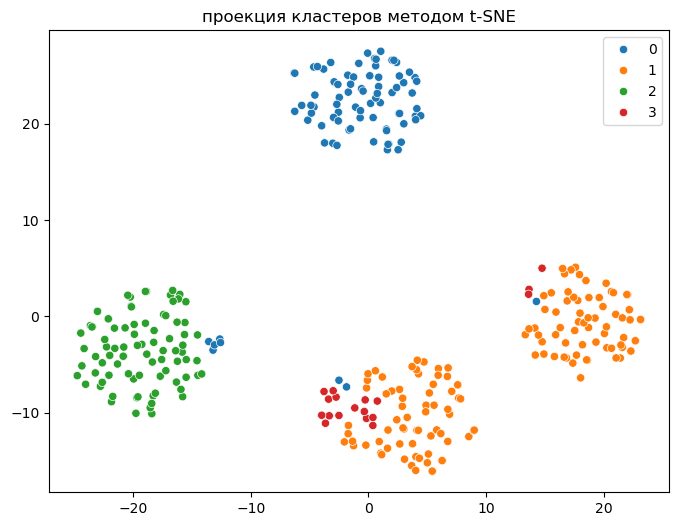

In [52]:
# шаг 6: проекция точек с помощью t-SNE (альтернатива SOM)

optimal_k=4

# кластерные метки для optimal_k
model = AgglomerativeClustering(n_clusters=optimal_k, linkage='complete', metric='manhattan')
labels = model.fit_predict(X_preprocessed)

# tsne-проекция
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_preprocessed)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10', legend='full')
plt.title('проекция кластеров методом t-SNE')
plt.show()


In [53]:
# шаг 7: кластеризация методом EM (GaussianMixture) и выбор типичных представителей

optimal_k=4

# EM-кластеризация
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_preprocessed)
df['Cluster_EM'] = gmm_labels

# находим представителя каждого кластера (минимизируем сумму квадратов отклонений)
representatives = {}
for cl in range(optimal_k):
    group = df[gmm_labels == cl]
    # берем те же нормализованные числовые фичи
    Xg = X_preprocessed[gmm_labels == cl, :len(num_features)]
    center = Xg.mean(axis=0)
    # евклидово расстояние
    dists = np.linalg.norm(Xg - center, axis=1)
    idx = np.argmin(dists)
    representatives[cl] = group.iloc[idx]['Name']

print("типичные представители по EM:", representatives)


типичные представители по EM: {0: 'Hassey, Ron', 1: 'Walling, Denny', 2: 'Henderson, Dave', 3: 'Van Slyke, Andy'}


c:\Users\aiksi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [ ]:
# шаг 8: объединение всего в функцию
def cluster_pipeline(df):


    df = df.copy()
    # imputation
    df['Salary'] = df['Salary'].values.reshape(-1, 1)
    imputer = KNNImputer(n_neighbors=3)
    df[['Salary']] = imputer.fit_transform(df[['Salary']])
    df['logSalary'] = np.log1p(df['Salary'])

    # preprocessing
    num_features = df.select_dtypes(include=[np.number]).columns.drop(['Salary'])
    cat_features = df.select_dtypes(include=['object']).columns.drop('Name')
    preprocessor = ColumnTransformer([
        ('num', MinMaxScaler(), list(num_features)),
        ('cat', OneHotEncoder(drop='first'), list(cat_features))
    ])
    X = preprocessor.fit_transform(df.drop(columns=['Name']))

    # hier clustering + optimal_k
    scores = []
    for k in range(2, 21):
        model = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='manhattan')
        labels = model.fit_predict(X)
        scores.append(calinski_harabasz_score(X, labels))
    # find first peak
    optimal_k = None
    for i in range(1, len(scores)-1):
        if scores[i] > scores[i-1] and scores[i] > scores[i+1]:
            optimal_k = i + 2
            break
    if optimal_k is None:
        optimal_k = int(np.argmax(scores)) + 2

    # t-SNE проекция
    labels_hier = AgglomerativeClustering(n_clusters=optimal_k, linkage='complete', affinity='manhattan')\
                  .fit_predict(X)
    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

    # EM кластеризация + представители
    gmm = GaussianMixture(n_components=optimal_k, random_state=42)
    labels_em = gmm.fit_predict(X)

    reps = {}
    for cl in range(optimal_k):
        mask = (labels_em == cl)
        Xg = X[mask, :len(num_features)]
        center = Xg.mean(axis=0)
        dists = np.linalg.norm(Xg - center, axis=1)
        idx = np.where(mask)[0][np.argmin(dists)]
        reps[cl] = df.iloc[idx]['Name']

    return {
        'optimal_k': optimal_k,
        'scores': scores,
        'tsne': X_tsne,
        'hier_labels': labels_hier,
        'em_labels': labels_em,
        'representatives': reps
    }


In [57]:
# шаг 9: дополнительная предобработка распределений
import pandas as pd
import numpy as np
from scipy.stats import skew

# загружаем исходные данные
df9 = pd.read_csv('baseball.csv')

# 1) knn-импутация пропусков и пересчёт logSalary
from sklearn.impute import KNNImputer
df9['Salary'] = df9['Salary'].values.reshape(-1,1)
imputer = KNNImputer(n_neighbors=3)
df9[['Salary']] = imputer.fit_transform(df9[['Salary']])
df9['logSalary'] = np.log1p(df9['Salary'])

# 2) ищем числовые признаки с сильным скошенным распределением
num_feats = df9.select_dtypes(include=[np.number]).columns.drop(['Salary'])
skews = df9[num_feats].apply(lambda x: skew(x.dropna()))
skewed = skews[skews > 1].index.tolist()

# 3) лог-преобразование тяжёлых правых хвостов
for feat in skewed:
    df9[feat] = np.log1p(df9[feat])

# 4) запускаем ранее определённую функцию кластеризации
results9 = cluster_pipeline(X_preprocessed)

# выводим результаты
print(f"skewed-features: {skewed}")
print(f"новое optimal_k: {results9['optimal_k']}")
print(f"новые представители: {results9['representatives']}")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices